In [1]:
"""Clustering and Bayesian probabilistic assignment of weather regimes.

This script is designed to assign individual weather patterns to weather regimes,
using a Bayesian probabilistic approach. The methodology allows for the identification and
classification of atmospheric conditions into distinct regimes, facilitating the study of
their impacts on climate and weather forecasts.

Author: Bram van Duinen

References
----------
- K-means clustering method adapted from Matteo De Felice's Recipe for Weather Regimes available at:
  https://github.com/matteodefelice/a-recipe-for-weather-regimes/blob/main/recipe.ipynb
  (Accessed on 28 Nov 2023).
- Bayesian probabilistic clustering adapted from Falkena et al. (2023), available at:
  https://journals.ametsoc.org/view/journals/clim/36/24/JCLI-D-22-0419.1.xml

"""

# importing modules
import ast
import sys
import os
import time

sys.path.append(os.path.abspath('../..'))

import numpy as np
import pandas as pd
from src import utils as ut
import xarray as xr
from config_ERA5 import (
    N_CLUSTERS,
    N_EOFS,
    N_EOFS_FOR_KMEANS,
    PATH_CLUSTERS,
    PATH_ZG500_ERA5,
    USE_SCALING,
    VERSION,
    THRES,
)
from eofs.xarray import Eof
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
# make output directory
DIR_CLUSTERS = os.path.join(PATH_CLUSTERS, VERSION)
ut.check_make_dir(DIR_CLUSTERS)

CENTROIDS_FILENAME = os.path.join(DIR_CLUSTERS, "centroids_unordered.nc")
DF_CLUSTERS_FULL_FILENAME = os.path.join(DIR_CLUSTERS, "df_clusters_full_unordered.csv")

In [3]:
# define functions
def load_data() -> xr.DataArray:
    """Load and preprocess zg500 data for a specific year, to calculate cluster centroids.

    Args:
    ----
    - year (int): The target year for data extraction.
    - run_mid (int): The middle run index for splitting the data.

    Returns:
    -------
    - df (xarray.DataArray): Preprocessed zg500 data.

    """
    filename = f"{PATH_ZG500_ERA5}era5_z500_d_v2.nc"
    df_1 = xr.open_dataset(
        filename,
        chunks={"longitude": 31, "latitude": 16, "time": -1},
    )

    df_1 = df_1.where(
        (df_1["time"].dt.month.isin([11, 12, 1, 2, 3]))
        & (  # only use one year per run for cluster centroids, add others later.
            df_1["lon"] < 30
        )
        & (df_1["lat"] > 20)
        & (df_1["lat"] < 80),
        drop=True,
    )

    return df_1.coarsen(lon=3, boundary="trim").mean().coarsen(lat=3, boundary="trim").mean()


def calculate_anomaly(da, groupby_type="time.dayofyear"):
    """Calculate anomalies based on a given grouping type (default = dayofyear).

    Parameters
    ----------
    - da (xarray.DataArray): Input climate data.
    - groupby_type (str): Grouping type for calculating anomalies.

    Returns
    -------
    - Anomalies (xarray.DataArray): Calculated anomalies.

    """
    gb = da.groupby(groupby_type)
    clim = gb.mean(dim="time")
    return gb - clim


def calculate_eofs(df_anom):
    """Calculate Empirical Orthogonal Functions (EOFs) from anomaly data.

    Parameters
    ----------
    - df_anom (xarray.DataArray): Anomaly data.

    Returns
    -------
    - solver, eofs, eofs_corr, explained_var: EOF-related results.

    """
    coslat = np.cos(np.deg2rad(df_anom.coords["lat"].values)).clip(0.0, 1.0)
    wgts = np.sqrt(coslat)[..., np.newaxis]
    solver = Eof(df_anom, weights=wgts)
    eofs = solver.eofs(neofs=N_EOFS)
    explained_var = solver.varianceFraction(neigs=N_EOFS_FOR_KMEANS)
    return solver, eofs, explained_var


def calculate_pcs(solver, df_anom):
    """Calculate Principal Components (PCs) from solver and zg500 anomaly data.

    Parameters
    ----------
    - solver: EOF solver.
    - df_anom (xarray.DataArray): Anomaly data.

    Returns
    -------
    - df_pcs (pd.DataFrame): Principal Components data.

    """
    pcs = solver.projectField(df_anom, neofs=N_EOFS, eofscaling=USE_SCALING)

    df_pcs = (
        pcs.to_dataframe()
        .reset_index()
        .assign(run_index=lambda df: df.groupby(["time", "mode"]).cumcount())
        .pivot(index=["time", "run_index"], columns="mode", values="pseudo_pcs")
        .add_prefix("EOF")
    )
    df_pcs.index = pd.to_datetime(df_pcs.index.get_level_values("time"))
    return df_pcs


def Kmeans_clustering(df_pcs):
    """Perform KMeans clustering on Principal Components.

    Parameters
    ----------
    - df_pcs (pd.DataFrame): Principal Components.

    Returns
    -------
    - clus, cluster_center_array: Cluster assignments and centroids.

    """
    X_train = df_pcs.iloc[:, 0:N_EOFS_FOR_KMEANS].values
    km = KMeans(
        n_clusters=N_CLUSTERS,
        n_init=500,
        verbose=0,
        tol=0.000001,
        max_iter=500,
        random_state=3,
    )
    km.fit(X_train)

    
    clus = pd.DataFrame(
        data=km.labels_, 
        columns=['cluster_id'], 
        index=df_pcs.index).reset_index()
    clus.rename(columns={'time': 'date'}, inplace=True)

    clus.set_index('date', inplace=True)

    # calculate centroids
    cluster_centers = pd.DataFrame(
        km.cluster_centers_,
        columns=[f"eof{i}" for i in np.arange(1, N_EOFS_FOR_KMEANS + 1)],
    )

    cluster_center_array = xr.DataArray(
        cluster_centers.values,
        coords=[np.arange(0, N_CLUSTERS), np.arange(0, N_EOFS_FOR_KMEANS)],
        dims=["centroids", "mode"],
    )

    return clus, cluster_center_array


def original_space(cluster_center_array, eofs):
    """Transform cluster centroids from EOF space back to the original space.

    Parameters
    ----------
    - cluster_center_array: Centroids in EOF space.
    - eofs: Empirical Orthogonal Functions.

    Returns
    -------
    - recons_cluster_centers_unweighted: Transformed cluster centroids.

    """
    eigenvectors20 = eofs.loc[0:N_EOFS_FOR_KMEANS, ...]
    recons_cluster_centers_weighted = cluster_center_array.dot(eigenvectors20)

    lats = recons_cluster_centers_weighted.coords["lat"].values

    coslat = np.cos(np.deg2rad(lats)).clip(0.0, 1.0)
    wgts = np.sqrt(coslat)

    weights_array = xr.DataArray(wgts, coords=[lats], dims=["lat"])
    recons_cluster_centers_unweighted = recons_cluster_centers_weighted / weights_array
    return recons_cluster_centers_unweighted


def gen_clusters():
    """Generate zg500 cluster centroids based on a specific year.

    Parameters
    ----------
    - year (int): The target year for cluster generation.

    Returns
    -------
    - clus, cluster_center_array, recons_cluster_centers_unweighted, solver, eofs: Cluster-related results.

    """
    print("Generating clusters")
    print("Loading data")
    df = load_data()

    print("Calculating anomalies")
    start_time = time.time()
    df_anom = df.map_blocks(calculate_anomaly, template=df.load())
    end_time = time.time()
    print(f"Anomalies calculated in {end_time - start_time} seconds")

    print("Calculating EOFs")
    solver, eofs, explained_var = calculate_eofs(df_anom)
    print(
        f"Explained variance by first {N_EOFS_FOR_KMEANS} EOFs: {100*np.sum(explained_var):.2f}%",
    )

    print("Calculating PCs")
    df_pcs = calculate_pcs(solver, df_anom)

    print("Performing clustering")
    cluster_center_array = Kmeans_clustering(df_pcs)
    recons_cluster_centers_unweighted = original_space(cluster_center_array, eofs)

    return recons_cluster_centers_unweighted

def assign_to_cluster(centroids):
    """Assign individual runs to pre-existing clusters.
    Also calculate pattern correlation, and apply no-cluster if correlation is too low.

    Parameters
    ----------
    - centroids: Cluster centroids (in real space).

    """
    df = load_data()
    df_anom = df.z500.map_blocks(calculate_anomaly, template=df.load())

    assignments = []
    all_errors = []
    projections = []

    for data_point in df_anom:
        distances = np.linalg.norm(centroids - data_point, axis=(1, 2))
        projection = np.dot(
            centroids.values.reshape(centroids.shape[0], -1),
            data_point.values.flatten(),
        )
        cluster_assignment = np.argmin(distances)

        assignments.append(cluster_assignment)
        all_errors.append(distances.tolist())
        projections.append(projection.tolist())

    return pd.DataFrame(
        {
            "time": df["time"].values,
            "cluster_id": assignments,
            "projections": projections,
            "all_errors": all_errors,
        },
    )

# standardising projections onto centroids, to Weather Regime index
def calc_wri(df_cluster_full):
    """Calculate the Weather Regime Index (WRI), based on standardised projections onto centroids."""
    projection_array = np.array(df_cluster_full["projections"].tolist())
    mean_projection = np.mean(projection_array, axis=0)
    std_projection = np.std(projection_array, axis=0)
    wri = (projection_array - mean_projection) / std_projection
    df_cluster_full["wri"] = wri.tolist()
    return df_cluster_full


def distance_obs_erai(data, theta):
    """Distance between regimes and data."""
    diff = data - theta  # Compute difference
    dist = np.linalg.norm(diff, axis=(1, 2))  # Compute norm of difference
    distn = dist / (data.shape[0] * data.shape[1])  # Normalise
    return distn


def normal_distr(mu, cov_inv, cov_det, k_nr, x):
    """Normal distribution to get probability based on mean and covariance."""
    nd = np.exp(-1 / 2 * np.dot((x - mu).T, np.dot(cov_inv, x - mu))) / np.sqrt(
        (2 * np.pi) ** k_nr * cov_det,
    )
    return nd


def prob_obs_erai_mvn(dist_obs, mean, covinv, covdet, k_nr):
    """Probability of the observations."""
    # Compute the probability of being in each of the regimes following MVN
    prob_dist_cond_mv = np.zeros(k_nr)
    # And conditional on each regime
    for k in range(k_nr):
        # Compute the PDF-value corresponding to the observations
        prob_dist_cond_mv[k] = normal_distr(
            mean[k],
            covinv[k],
            covdet[k],
            k_nr,
            dist_obs,
        )

    # Convert this to a probability of being in each of the regimes (normalisation)
    prob_reg_obs = prob_dist_cond_mv / np.sum(prob_dist_cond_mv)

    return prob_reg_obs


def get_Bayes_parameters(df_cluster, k_nr):
    """Compute the prior, transition matrix, and parameters for the Bayesian probabilistic assignment."""
    p_c = df_cluster["cluster_id"].value_counts(normalize=True)

    tau_counter = np.zeros((N_CLUSTERS, N_CLUSTERS))
    cluster_counter = np.zeros(N_CLUSTERS)

    for i in range(len(df_cluster) - 1):
        cluster_now = df_cluster.iloc[i]["cluster_id"]

        if (df_cluster.iloc[i]["time"].month == 3) and (df_cluster.iloc[i]["time"].day == 31):
            continue  # Don't compare year-on-year transitions

        cluster_next = df_cluster.iloc[i + 1]["cluster_id"]

        tau_counter[cluster_now, cluster_next] += 1
        cluster_counter[cluster_now] += 1

    tau_matrix = tau_counter / cluster_counter[:, None]

    dmean = np.zeros((k_nr, k_nr))
    dcov = np.zeros((k_nr, k_nr, k_nr))
    dcov_inv = np.zeros((k_nr, k_nr, k_nr))
    dcov_det = np.zeros(k_nr)

    for k in range(k_nr):
        clust_errors = np.vstack(
            (df_cluster.query("cluster_id == @k")["all_errors"].to_numpy()).tolist(),
        )
        dmean[k] = np.mean(clust_errors, axis=0)
        dcov[k] = np.cov(clust_errors.T)
        dcov_inv[k] = np.linalg.inv(dcov[k])  # Inverse
        dcov_det[k] = np.linalg.det(dcov[k])  # Determinant
    return p_c, tau_matrix, dmean, dcov_inv, dcov_det


def bayes_posterior(
    df_cluster,
    p_c,
    tau_matrix,
    dmean,
    dcov_inv,
    dcov_det,
    thres,
    k_nr,
):
    """Compute the posterior probability of each regime using Bayes theorem. Apply hard assignment if posterior is above certain threshold."""
    likelihood = np.zeros((len(df_cluster), k_nr))
    prior = np.zeros((len(df_cluster), k_nr))
    prior[0] = p_c  # Initial prior

    # Initialize obtained regime probabilities
    post = np.zeros((len(df_cluster), k_nr))
    hard_assignment = np.zeros(len(df_cluster), dtype=int)
    hard_assignment_raw = np.zeros(len(df_cluster), dtype=int)

    for t in range(len(df_cluster)):
        # Compute observed probabilities
        likelihood[t] = prob_obs_erai_mvn(
            np.asarray(df_cluster.iloc[t]["all_errors"]),
            dmean,
            dcov_inv,
            dcov_det,
            k_nr,
        )

        # Compute the posterior
        post_temp = likelihood[t] * prior[t]
        post[t] = post_temp / np.sum(post_temp)
        hard_assignment[t] = np.argmax(post[t])
        hard_assignment_raw[t] = np.argmax(post[t])  # Raw assignment, no ro-regime
        if np.max(post[t]) < thres:
            hard_assignment[t] = k_nr  # No regime

        # Get the new prior
        if t + 1 < len(df_cluster):
            if df_cluster.iloc[t]["time"].month == 3 and df_cluster.iloc[t]["time"].day == 31:
                prior[t + 1] = p_c
            else:
                # next prior based on transition probility
                prior[t + 1] = np.dot(tau_matrix, post[t].T).T

    return prior, likelihood, post, hard_assignment_raw, hard_assignment


In [4]:
def plot_clusters(centroids_real_space, lons, lats):
    """Plot zg500 clusters on a map.

    Parameters
    ----------
    - centroids_real_space: Transformed cluster centers.
    - lons, lats: Longitude and Latitude values.

    """
    n_clusters = centroids_real_space.shape[0]
    levels_z500 = np.arange(5000, 6000, 80)

    fig, axs = plt.subplots(2, 2, figsize=(9, 6),
                            subplot_kw={"projection": ccrs.LambertConformal(central_longitude=-30, central_latitude=50)})

    axs = axs.flatten()
    titles = ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"]

    for i, ax in enumerate(axs):
        if i < n_clusters:
            ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()],
                          crs=ccrs.PlateCarree())
            fill = ax.contourf(
                lons,
                lats,
                centroids_real_space[i, :, :].squeeze(),
                levels=np.linspace(-200, 200, 21),
                cmap=plt.cm.RdBu_r,
                extend="both",
                transform=ccrs.PlateCarree())
            ax.coastlines(resolution="50m")
            ax.gridlines()
            ax.set_title(f"{titles[i]}", fontsize=12)

    cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
    cb = fig.colorbar(fill, cax=cbar_ax, orientation="vertical", label="500 hPa height anomaly [m]", extend="both", ticks=np.arange(-200, 250, 50))

In [5]:
def calculate_persistency_stats(df, date_col="time", cluster_col="cluster_id"):
    df[date_col] = pd.to_datetime(df[date_col])

    # Calculate the difference in days within each cluster
    df["date_diff"] = df.groupby(cluster_col)[date_col].diff().dt.days
    df["new_streak"] = df["date_diff"] != 1

    # Create a new group identifier for each streak
    df["streak_id"] = df.groupby(cluster_col)["new_streak"].cumsum()

    # Calculate the length of each streak
    streak_lengths = df.groupby([cluster_col, "streak_id"]).size().reset_index(name="streak_length")

    # Calculate the average, median, standard deviation, and maximum persistency
    persistency_stats = streak_lengths.groupby(cluster_col).agg(["mean", "median", "std", "max"])

    return persistency_stats, streak_lengths

In [6]:
# initial clustering, calculating centroids

df = load_data()
df_anom = df.z500.map_blocks(calculate_anomaly, template=df.load())
solver, eofs, explained_var = calculate_eofs(df_anom)
print(
    f"Explained variance by first {N_EOFS_FOR_KMEANS} EOFs: {100*np.sum(explained_var):.2f}%",
)

df_pcs = calculate_pcs(solver, df_anom)
clus_df, cluster_center_array = Kmeans_clustering(df_pcs)
recons_cluster_centers_unweighted = original_space(cluster_center_array, eofs)

/usr/people/duinen/anaconda3_v2/lib/python3.11/site-packages/xarray/core/indexing.py:1452: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


Explained variance by first 20 EOFs: 93.49%


In [7]:
# second clustering, with Bayesian correction. Like 'clustering per run', but can now be done in one go due to small dataset

df_cluster_full = assign_to_cluster(recons_cluster_centers_unweighted)

df_cluster_full = calc_wri(df_cluster_full)

# perform Bayesian probabilistic assignment
print("Performing Bayesian probabilistic assignment...")
p_c, tau_matrix, dmean, dcov_inv, dcov_det = get_Bayes_parameters(
    df_cluster_full,
    N_CLUSTERS,
)

prior, likelihood, post, hard_assignment_raw, hard_assignment = bayes_posterior(
    df_cluster_full,
    p_c,
    tau_matrix,
    dmean,
    dcov_inv,
    dcov_det,
    THRES,
    N_CLUSTERS,
)

df_cluster_full["Bayes_cluster"] = hard_assignment
df_cluster_full["Bayes_cluster_raw"] = hard_assignment_raw
df_cluster_full["prior"] = prior.tolist()
df_cluster_full["likelihood"] = likelihood.tolist()
df_cluster_full["posterior"] = post.tolist()

/usr/people/duinen/anaconda3_v2/lib/python3.11/site-packages/xarray/core/indexing.py:1452: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


Performing Bayesian probabilistic assignment...


(array([0.18866045, 0.26057422, 0.18621502, 0.22017933, 0.14437098]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5]),
 <BarContainer object of 5 artists>)

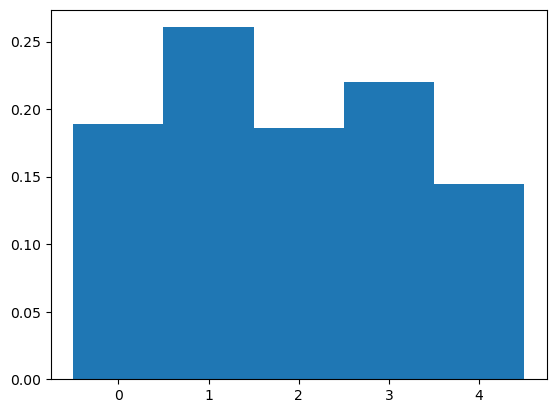

In [8]:
plt.hist(df_cluster_full['Bayes_cluster'], bins=np.arange(0, N_CLUSTERS+2)-0.5, density=True)

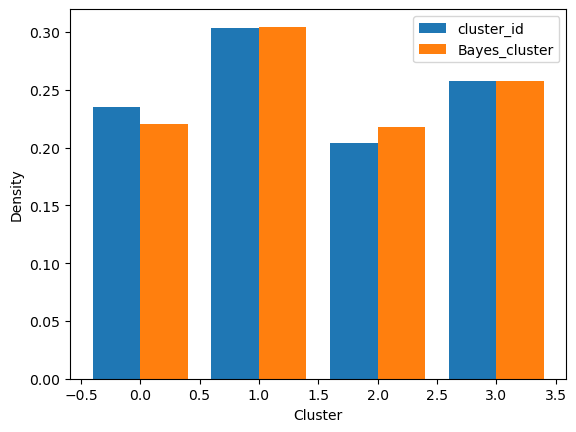

In [9]:
# Calculate the histograms
hist1, bin_edges = np.histogram(clus_df['cluster_id'], bins=np.arange(0, N_CLUSTERS+1)-0.5, density=True)
hist2, _ = np.histogram(df_cluster_full['Bayes_cluster'], bins=np.arange(0, N_CLUSTERS+1)-0.5, density=True)

# Define the width of the bars and the positions
width = 0.4
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot the bars side by side
plt.bar(bin_centers - width/2, hist1, width=width, label='cluster_id')
plt.bar(bin_centers + width/2, hist2, width=width, label='Bayes_cluster')

# Add labels and legend
plt.xlabel('Cluster')
plt.ylabel('Density')
plt.legend()

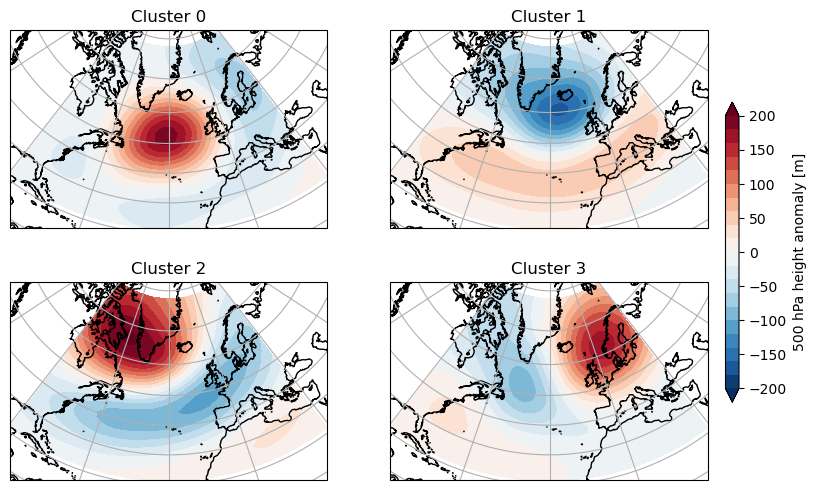

In [10]:
plot_clusters(recons_cluster_centers_unweighted, df.lon, df.lat)

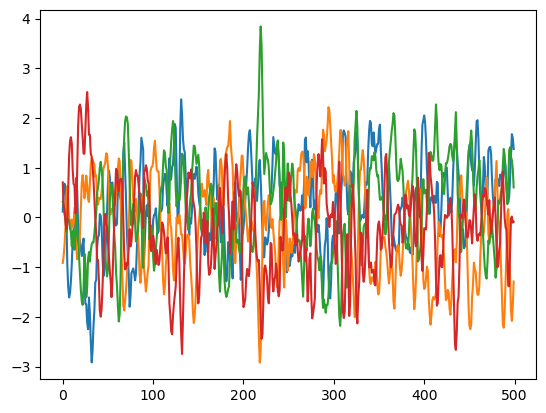

In [11]:
wri = np.array(df_cluster_full['wri'].tolist())
plt.plot(wri[:500])

In [12]:
pers_stats, streak_lengths = calculate_persistency_stats(
    df_cluster_full,
    cluster_col="Bayes_cluster",
)

In [13]:
pers_stats

streak_id                          streak_length         \
                   mean median         std   max          mean median   
Bayes_cluster                                                           
0                 217.5  217.5  125.429263   434      4.799539    3.0   
1                 227.5  227.5  131.202769   454      6.337004    5.0   
2                 135.5  135.5   78.086491   270      7.614815    5.0   
3                 206.5  206.5  119.078406   412      5.900485    4.0   
4                 559.5  559.5  322.883106  1118      1.425760    1.0   

                             
                    std max  
Bayes_cluster                
0              4.361696  26  
1              6.111806  48  
2              6.509342  34  
3              5.058519  29  
4              0.840630   8

In [16]:
df_cluster_full.to_csv(DF_CLUSTERS_FULL_FILENAME)
recons_cluster_centers_unweighted.to_netcdf(CENTROIDS_FILENAME)